In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil, scipy
sys.path.append('../')
from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    #print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [3]:
DAT = np.loadtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT7 = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt')
meanr7, xi7, xi_err7 = [DAT7[:,i] for i in range(3)]

DAT11 = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt')
meanr11, xi11, xi_err11 = [DAT11[:,i] for i in range(3)]

cov_cmass_n = np.genfromtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.cov')
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
cov_dmass = np.genfromtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.cov')

from numpy.linalg import inv


HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFn = HF(100, 10)
HFs = HF(100, 10)
HFd = HF(100, 10)

print HFn

F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_cmass_s)
F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_dmass)
F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s) + np.linalg.inv(cov_dmass)

0.888888888889


In [4]:
from scipy.interpolate import interp1d

In [5]:
theta_th, w_theory = np.loadtxt('../data_txt/acf_cmass_theory.txt', unpack=True)
import scipy
w_theory = interp1d(theta_th, w_theory, kind='cubic')
w_theory = w_theory(meanr11)

In [6]:
np.sqrt(cov_dmass.diagonal())

array([0.01161673, 0.00972351, 0.00667849, 0.00514763, 0.00462449,
       0.00344142, 0.00322357, 0.00284346, 0.00290399, 0.00253571])

In [7]:
mock_n = np.random.multivariate_normal( w_theory, cov_cmass_n, size=5000 )
mock_s = np.random.multivariate_normal( w_theory, cov_cmass_s, size=5000 )
mock_d = np.random.multivariate_normal( w_theory, cov_dmass, size=5000 )

<Container object of 3 artists>

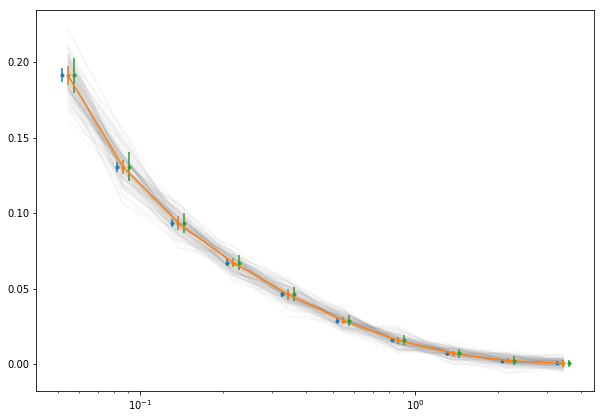

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(100): 
    ax.semilogx(meanr, mock_d[i], color='grey', alpha = 0.05)
ax.errorbar(meanr*0.95, w_theory, yerr=np.sqrt(cov_cmass_n.diagonal()), fmt='.')
ax.errorbar(meanr, w_theory, yerr=np.sqrt(cov_cmass_s.diagonal()), fmt='.-')
ax.errorbar(meanr*1.05, w_theory, yerr=np.sqrt(cov_dmass.diagonal()), fmt='.')

In [47]:
brel_ns = np.zeros(5000)
chisqr_array_ns = np.zeros((5000, 5000))
brel_sd = np.zeros(5000)
chisqr_array_sd = np.zeros((5000, 5000))

brel_nd = np.zeros(5000)
chisqr_array_nd = np.zeros((5000, 5000))

for i in range(5000):
    _, brel_ns[i], chisqr_array_ns[i] = brel_chisqr_fitting(mock_s[i], mock_n[i], F_ns)
    _, brel_nd[i], chisqr_array_nd[i] = brel_chisqr_fitting(mock_d[i], mock_n[i], F_nd)
    _, brel_sd[i], chisqr_array_sd[i] = brel_chisqr_fitting(mock_d[i], mock_s[i], F_sd)
    print i, '\r',
    #brel_n.append(brel_ns)
    #c3hisqr_array_n.append(chisqr_result_ns)
#err_db_nd, db_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xi11, F_nd)
#err_db_sd, db_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xi7, F_sd)
#err_db_ns_nzs_ratio, db_ns_nzs_ratio, chisqr_result_ns_nzs_ratio = brel_chisqr_fitting(xi7,  xi11*nzs_ratio, F_ns)

bshift_ns= 1.- np.mean(brel_ns)
bshift_nd=  1.-np.mean(brel_nd)
bshift_sd=  1.-np.mean(brel_sd)

print 1.- np.mean(brel_ns)
print 1.-np.mean(brel_nd)
print 1.-np.mean(brel_sd)

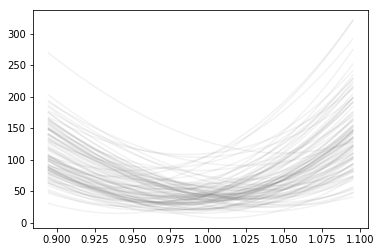

In [56]:
brelsqr = np.linspace(0.8, 1.2, 5000)   
brelarr = np.sqrt(brelsqr) 
    
fig, ax = plt.subplots()
for i in range(100):
    ax.plot(brelarr, chisqr_array_sd[i], color='grey', alpha = 0.1)


0.003335676829593459
0.009435865794644616
0.006185833655411255


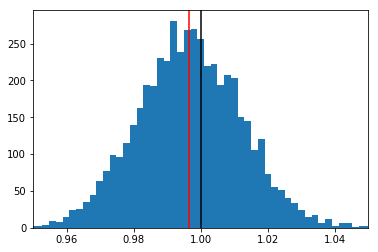

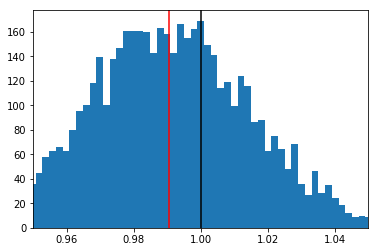

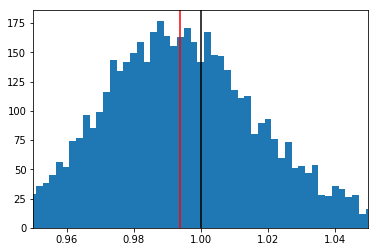

In [55]:
bins, bs = np.linspace(0.8, 1.2, 200, retstep=True)
bincent = bins[:-1] + bs/2.

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_ns, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_ns)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.95, 1.05)

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_nd, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_nd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.95, 1.05)

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_sd, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_sd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.95, 1.05)

print 1.- np.mean(brel_ns)
print 1.-np.mean(brel_nd)
print 1.-np.mean(brel_sd)